## Product Analytics and Recommendations on Online Retail data

In this file, we will be focusing on analysing the different products for Online Retail

#### 1. Importing libraries and data

In [63]:
import pandas as pd
import numpy as np
import calendar
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity

In [64]:
df = pd.read_excel('./data/Online Retail.xlsx', sheet_name='Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Let’s have a look at the oldest and earliest date.

In [65]:
print('Oldest Date: ' + str(df['InvoiceDate'].min()))
print('Earliest Date: ' + str(df['InvoiceDate'].max()))

Oldest Date: 2010-12-01 08:26:00
Earliest Date: 2011-12-09 12:50:00


We are going to analyse all dates between 2010/12/01 and 2011/11/30 to look at exactly one whole year.

In [66]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

#### 2. Product Analtyics

#### 2.1 Number of Orders over Time

In [67]:
df1 = df.copy()
df1['Month'] = df1['InvoiceDate'].dt.month
df1['Year'] = df1['InvoiceDate'].dt.year

df1.groupby(['Month','Year'])['InvoiceNo'].agg('nunique').reset_index().sort_values(by = ['Year','Month'], ascending = [True,True])

,Month,Year,InvoiceNo
11,12,2010,2025
0,1,2011,1476
1,2,2011,1393
2,3,2011,1983
3,4,2011,1744
4,5,2011,2162
5,6,2011,2012
6,7,2011,1927
7,8,2011,1737
8,9,2011,2327


In [68]:
## Alternative way to get the same result
df_monthly_orders = df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()

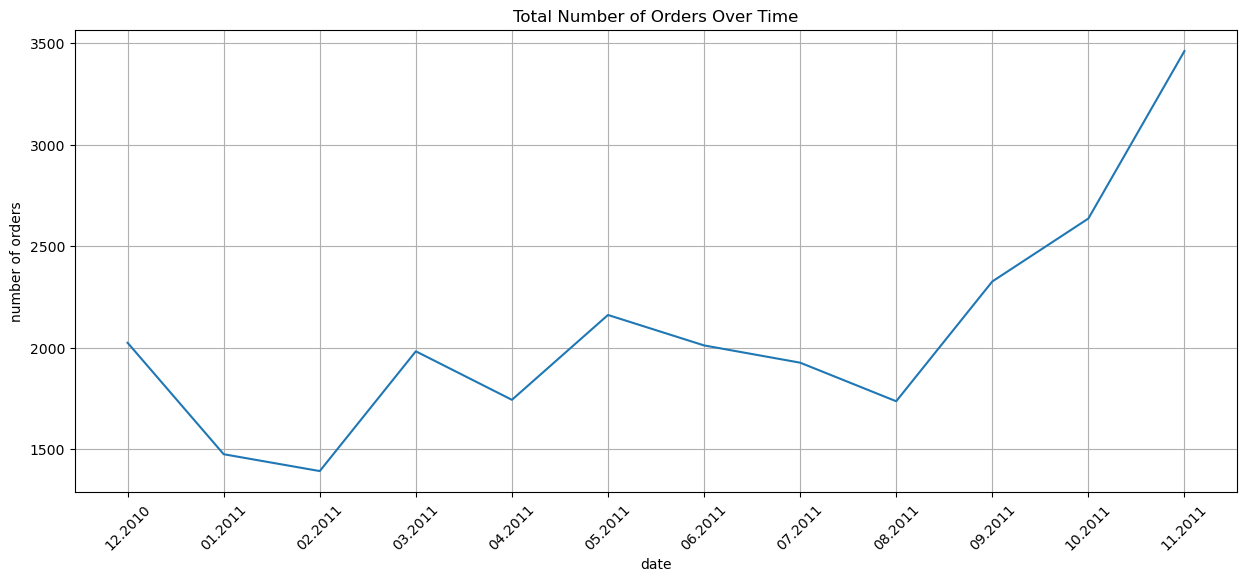

In [69]:
## Plotting the number of unique invoices per month
ax = pd.DataFrame(df_monthly_orders.values).plot(
    grid=True,
    figsize=(15,6),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('number of orders')
ax.set_title('Total Number of Orders Over Time')

plt.xticks(
    range(len(df_monthly_orders.index)), 
    [x.strftime('%m.%Y') for x in df_monthly_orders.index], 
    rotation=45
)

plt.show()

#### 2.2 Revenue over Time

Let’s create a new sales-column for revenue.

In [70]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [71]:
df_monthly_revenue = df.set_index('InvoiceDate')['Sales'].resample('M').sum()

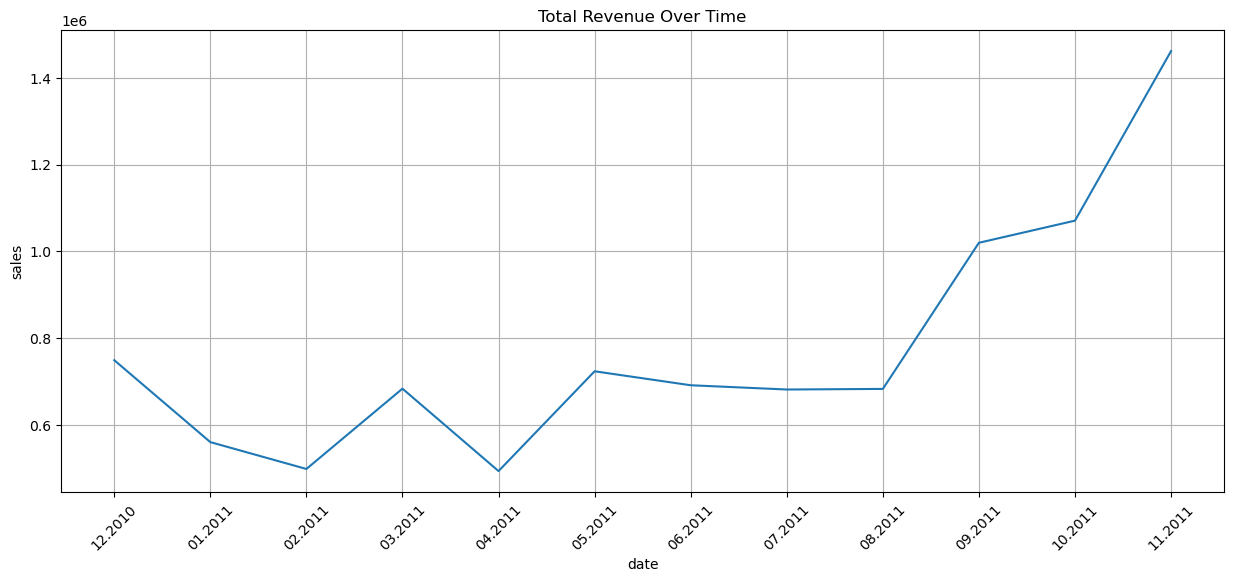

In [72]:
ax = pd.DataFrame(df_monthly_revenue.values).plot(
    grid=True,
    figsize=(15,6),
    legend=False
)

ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.set_title('Total Revenue Over Time')

plt.xticks(
    range(len(df_monthly_revenue.index)), 
    [x.strftime('%m.%Y') for x in df_monthly_revenue.index], 
    rotation=45
)

plt.show()

#### 2.3 Repeat Customers over Time

In [73]:
df['InvoiceNo'].head()

0    536365
1    536365
2    536365
3    536365
4    536365
Name: InvoiceNo, dtype: object

Due to the fact that we have multiple records for one purchase order (InvoiceNo), we have to aggregate data for each order, so that one record in the dataset represents one purchase order.

In [74]:
df_invoice_customer = df.groupby(by=['InvoiceNo', 'InvoiceDate']).agg({
    'Sales': sum,
    'CustomerID': max,
    'Country': max,
}).reset_index()

df_invoice_customer.head()

,InvoiceNo,InvoiceDate,Sales,CustomerID,Country
0,536365,2010-12-01 08:26:00,139.12,17850.0,United Kingdom
1,536366,2010-12-01 08:28:00,22.20,17850.0,United Kingdom
2,536367,2010-12-01 08:34:00,278.73,13047.0,United Kingdom
3,536368,2010-12-01 08:34:00,70.05,13047.0,United Kingdom
4,536369,2010-12-01 08:35:00,17.85,13047.0,United Kingdom


In [84]:
df_invoice_customer.dtypes

InvoiceNo              object
InvoiceDate    datetime64[ns]
Sales                 float64
CustomerID            float64
Country                object
dtype: object

'''Here we generate a record that shows the **number of repeat customers by month**. Furthermore, we enrich the data set with a separate column for the month and the year.'''

In [89]:
df_monthly_repeat_customers = df_invoice_customer.set_index('InvoiceDate').groupby([pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M').nunique()['CustomerID']

# Create dataframe from output
df_monthly_repeat_customers = pd.DataFrame(df_monthly_repeat_customers).reset_index()
df_monthly_repeat_customers = df_monthly_repeat_customers.rename(columns={'CustomerID':'repeat_customer_count'})

In [76]:
# Extract month (numeric and advertised) and year 
df_monthly_repeat_customers['month'] = df_monthly_repeat_customers['InvoiceDate'].dt.month
df_monthly_repeat_customers['Month_Name'] = df_monthly_repeat_customers['month'].apply(lambda x: calendar.month_name[x])
df_monthly_repeat_customers['year'] = df_monthly_repeat_customers['InvoiceDate'].dt.year
df_monthly_repeat_customers

,InvoiceDate,repeat_customer_count,month,Month_Name,year
0,2010-12-31,357,12,December,2010
1,2011-01-31,256,1,January,2011
2,2011-02-28,246,2,February,2011
3,2011-03-31,323,3,March,2011
4,2011-04-30,271,4,April,2011
5,2011-05-31,398,5,May,2011
6,2011-06-30,333,6,June,2011
7,2011-07-31,327,7,July,2011
8,2011-08-31,299,8,August,2011
9,2011-09-30,400,9,September,2011


'''Here we generate a data set that shows the **number of unique customers by month**. Furthermore, we enrich the data set with a separate column for the month and the year.'''

In [88]:
df_monthly_unique_customers = df_invoice_customer.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()

# Create dataframe from output
df_monthly_unique_customers = pd.DataFrame(df_monthly_unique_customers).reset_index()
df_monthly_unique_customers = df_monthly_unique_customers.rename(columns={'CustomerID':'customer_count_unique'})

In [78]:
# Extract month (numeric and advertised) and year 
df_monthly_unique_customers['month'] = df_monthly_unique_customers['InvoiceDate'].dt.month
df_monthly_unique_customers['Month_Name'] = df_monthly_unique_customers['month'].apply(lambda x: calendar.month_name[x])
df_monthly_unique_customers['year'] = df_monthly_unique_customers['InvoiceDate'].dt.year
df_monthly_unique_customers

,InvoiceDate,customer_count_unique,month,Month_Name,year
0,2010-12-31,948,12,December,2010
1,2011-01-31,783,1,January,2011
2,2011-02-28,798,2,February,2011
3,2011-03-31,1020,3,March,2011
4,2011-04-30,899,4,April,2011
5,2011-05-31,1079,5,May,2011
6,2011-06-30,1051,6,June,2011
7,2011-07-31,993,7,July,2011
8,2011-08-31,980,8,August,2011
9,2011-09-30,1302,9,September,2011


'''Here we generate a data set that shows the **percentage of repeat customers by month**. Furthermore, we enrich the data set with a separate column for the month and the year.'''

In [ ]:
# Calculate percentage of repeat customers
df_monthly_repeat_percentage = df_monthly_repeat_customers['repeat_customer_count']/df_monthly_unique_customers['customer_count_unique']*100.0

# Create dataframe from output
df_monthly_repeat_percentage = pd.DataFrame(df_monthly_repeat_percentage).reset_index().drop(["index"], axis = 1)

# Add according InvoiceDate from one of the previous created dataframes
df_monthly_repeat_percentage['InvoiceDate'] = df_monthly_unique_customers['InvoiceDate']

# Rearrange Columns
cols = list(df_monthly_repeat_percentage.columns)
cols = [cols[-1]] + cols[:-1]
df_monthly_repeat_percentage = df_monthly_repeat_percentage[cols]

# Rename Columns
df_monthly_repeat_percentage.columns = ['InvoiceDate','Repeat_Percentage']

,InvoiceDate,Repeat_Percentage
0,2010-12-31,37.658228
1,2011-01-31,32.694764
2,2011-02-28,30.827068
3,2011-03-31,31.666667
4,2011-04-30,30.144605
5,2011-05-31,36.886006
6,2011-06-30,31.684110
7,2011-07-31,32.930514
8,2011-08-31,30.510204
9,2011-09-30,30.721966


In [80]:
# Extract month (numeric and advertised) and year 
df_monthly_repeat_percentage['month'] = df_monthly_repeat_percentage['InvoiceDate'].dt.month
df_monthly_repeat_percentage['Month_Name'] = df_monthly_repeat_percentage['month'].apply(lambda x: calendar.month_name[x])
df_monthly_repeat_percentage['year'] = df_monthly_repeat_percentage['InvoiceDate'].dt.year

df_monthly_repeat_percentage

,InvoiceDate,Repeat_Percentage,month,Month_Name,year
0,2010-12-31,37.658228,12,December,2010
1,2011-01-31,32.694764,1,January,2011
2,2011-02-28,30.827068,2,February,2011
3,2011-03-31,31.666667,3,March,2011
4,2011-04-30,30.144605,4,April,2011
5,2011-05-31,36.886006,5,May,2011
6,2011-06-30,31.684110,6,June,2011
7,2011-07-31,32.930514,7,July,2011
8,2011-08-31,30.510204,8,August,2011
9,2011-09-30,30.721966,9,September,2011


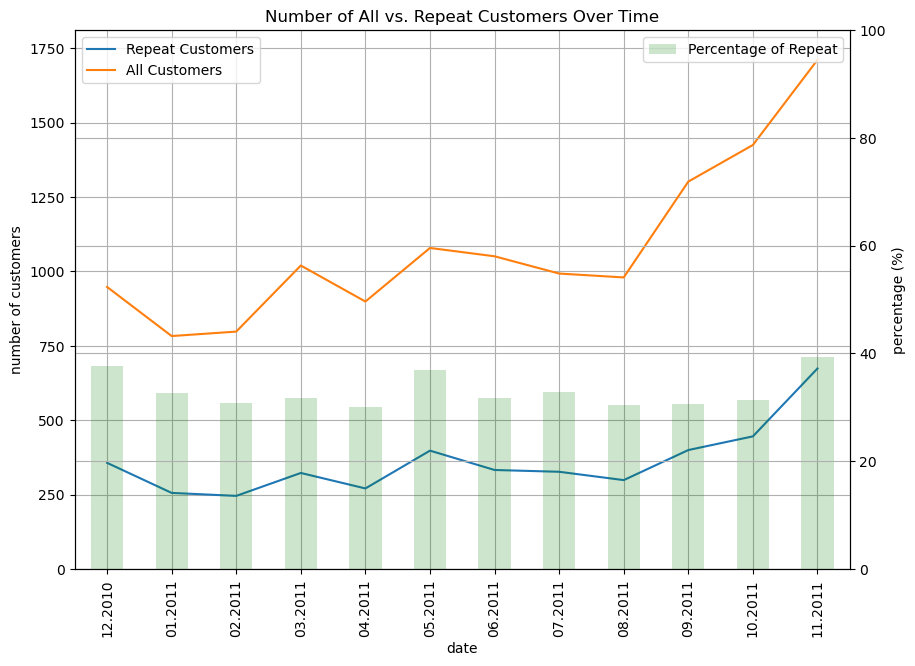

In [81]:
ax = pd.DataFrame(df_monthly_repeat_customers['repeat_customer_count'].values).plot(figsize=(10,7))

pd.DataFrame(df_monthly_unique_customers['customer_count_unique'].values).plot(ax=ax,grid=True)


ax2 = pd.DataFrame(df_monthly_repeat_percentage['Repeat_Percentage'].values).plot.bar(ax=ax,grid=True,secondary_y=True,color='green',alpha=0.2)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('Number of All vs. Repeat Customers Over Time')

ax2.set_ylabel('percentage (%)')

ax.legend(['Repeat Customers', 'All Customers'])
ax2.legend(['Percentage of Repeat'], loc='upper right')

ax.set_ylim([0, df_monthly_unique_customers['customer_count_unique'].values.max()+100])
ax2.set_ylim([0, 100])

plt.xticks(
    range(len(df_monthly_repeat_percentage['InvoiceDate'])), 
    [x.strftime('%m.%Y') for x in df_monthly_repeat_percentage['InvoiceDate']], 
    rotation=45
)

plt.show()

#### 2.4 Repeat Customers Revenue over Time

'''Here we generate a record that shows the **revenue of repeat customers by month**. Furthermore, we enrich the data set with a separate column for the month and the year.'''

In [87]:
df_monthly_rev_repeat_customers = df_invoice_customer.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M')['Sales'].sum()

# Create dataframe from output
df_monthly_rev_repeat_customers = pd.DataFrame(df_monthly_rev_repeat_customers).reset_index()
df_monthly_rev_repeat_customers = df_monthly_rev_repeat_customers.rename(columns={'CustomerID':'repeat_customer_revenue'})

In [91]:
# Extract month (numeric and advertised) and year 
df_monthly_rev_repeat_customers['month'] = df_monthly_rev_repeat_customers['InvoiceDate'].dt.month
df_monthly_rev_repeat_customers['Month_Name'] = df_monthly_rev_repeat_customers['month'].apply(lambda x: calendar.month_name[x])
df_monthly_rev_repeat_customers['year'] = df_monthly_rev_repeat_customers['InvoiceDate'].dt.year
df_monthly_rev_repeat_customers

,InvoiceDate,Sales,month,Month_Name,year
0,2010-12-31,382021.39,12,December,2010
1,2011-01-31,263878.59,1,January,2011
2,2011-02-28,223091.71,2,February,2011
3,2011-03-31,326507.60,3,March,2011
4,2011-04-30,218592.06,4,April,2011
5,2011-05-31,404843.47,5,May,2011
6,2011-06-30,374397.20,6,June,2011
7,2011-07-31,346158.02,7,July,2011
8,2011-08-31,347282.63,8,August,2011
9,2011-09-30,554521.59,9,September,2011


In [93]:
df_monthly_rev_perc_repeat_customers = df_monthly_rev_repeat_customers['Sales']/df_monthly_revenue.values * 100.0
df_monthly_rev_perc_repeat_customers

0     51.007118
1     47.121155
2     44.791897
3     47.786233
4     44.320540
5     55.969130
6     54.172287
7     50.808449
8     50.870447
9     54.381516
10    54.212831
11    51.000890
Name: Sales, dtype: float64

In [94]:
# Create dataframe from output
df_monthly_rev_perc_repeat_customers = pd.DataFrame(df_monthly_rev_perc_repeat_customers).reset_index().drop(["index"], axis = 1)

# Add according InvoiceDate from one of the previous created dataframes
df_monthly_rev_perc_repeat_customers['InvoiceDate'] = df_monthly_rev_repeat_customers['InvoiceDate']

# Rearrange Columns
cols = list(df_monthly_rev_perc_repeat_customers.columns)
cols = [cols[-1]] + cols[:-1]
df_monthly_rev_perc_repeat_customers = df_monthly_rev_perc_repeat_customers[cols]

# Rename Columns
df_monthly_rev_perc_repeat_customers.columns = ['InvoiceDate','Repeat_Cust_Rev_Percentage']

df_monthly_rev_perc_repeat_customers

,InvoiceDate,Repeat_Cust_Rev_Percentage
0,2010-12-31,51.007118
1,2011-01-31,47.121155
2,2011-02-28,44.791897
3,2011-03-31,47.786233
4,2011-04-30,44.320540
5,2011-05-31,55.969130
6,2011-06-30,54.172287
7,2011-07-31,50.808449
8,2011-08-31,50.870447
9,2011-09-30,54.381516


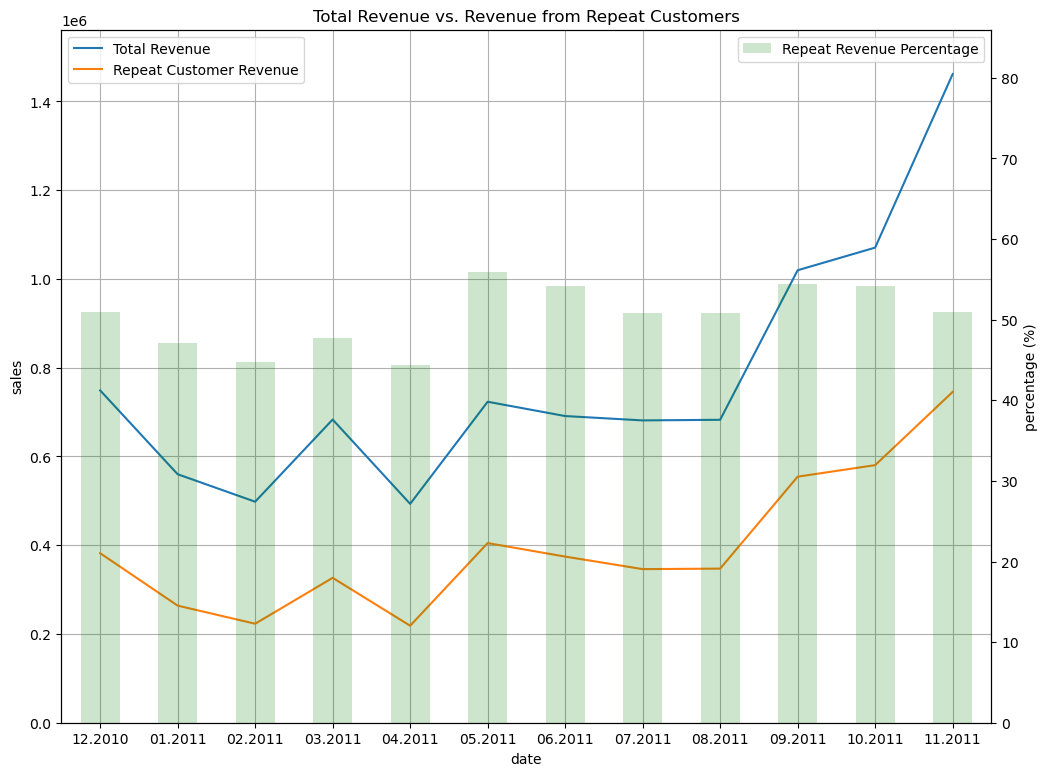

In [101]:
ax = pd.DataFrame(df_monthly_revenue.values).plot(figsize=(12,9))

pd.DataFrame(df_monthly_rev_repeat_customers['Sales'].values).plot(ax=ax, grid=True)

ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.set_title('Total Revenue vs. Revenue from Repeat Customers')

ax.legend(['Total Revenue', 'Repeat Customer Revenue'])

ax.set_ylim([0, max(df_monthly_revenue.values)+100000])

ax2 = ax.twinx()

pd.DataFrame(df_monthly_rev_perc_repeat_customers['Repeat_Cust_Rev_Percentage'].values).plot(ax=ax2,kind='bar', color='g',alpha=0.2)

ax2.set_ylim([0, max(df_monthly_rev_perc_repeat_customers['Repeat_Cust_Rev_Percentage'].values)+30])
ax2.set_ylabel('percentage (%)')
ax2.legend(['Repeat Revenue Percentage'])

ax2.set_xticklabels([
    x.strftime('%m.%Y') for x in df_monthly_rev_perc_repeat_customers['InvoiceDate']
])

plt.show()

#### 2.5 Popular Items over Time

'''Here we create a dataset that is filtered to month = november and year = 2011. '''

In [102]:
df_pop_items = df

df_pop_items['month'] = df_pop_items['InvoiceDate'].dt.month
df_pop_items['Month_Name'] = df_pop_items['month'].apply(lambda x: calendar.month_name[x])
df_pop_items['year'] = df_pop_items['InvoiceDate'].dt.year

df_pop_items = df_pop_items[(df_pop_items["month"] == 11) & (df_pop_items["year"] == 2011)]  

df_pop_items.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,month,Month_Name,year
431673,573744,21314,SMALL GLASS HEART TRINKET POT,8,2011-11-01 08:16:00,2.10,17733.0,United Kingdom,16.8,11,November,2011
431674,573744,21704,BAG 250g SWIRLY MARBLES,12,2011-11-01 08:16:00,0.85,17733.0,United Kingdom,10.2,11,November,2011
431675,573744,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,15.0,11,November,2011
431676,573744,21892,TRADITIONAL WOODEN CATCH CUP GAME,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,15.0,11,November,2011
431677,573744,21915,RED HARMONICA IN BOX,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,15.0,11,November,2011


In [105]:
# Rank items
df_last_month_sorted = df_pop_items[['InvoiceDate', 'StockCode', 'Quantity']]
df_last_month_sorted = df_last_month_sorted[['InvoiceDate', 'StockCode', 'Quantity']].sort_values(by='Quantity', ascending=False).reset_index()
df_last_month_sorted = df_last_month_sorted.drop(["index"], axis = 1)
df_last_month_sorted.head()

,InvoiceDate,StockCode,Quantity
0,2011-11-25 15:57:00,84826,12540
1,2011-11-02 11:24:00,16014,3000
2,2011-11-03 15:47:00,21915,2100
3,2011-11-29 15:52:00,23084,2040
4,2011-11-07 17:42:00,22197,1820


In [106]:
# Regroup for top 5 items
df_date_item = pd.DataFrame(
    df.loc[df['StockCode'].isin([84826, 16014, 21915, 23084, 22197])].set_index('InvoiceDate').groupby([pd.Grouper(freq='M'), 'StockCode'])['Quantity'].sum()
)
df_date_item.head()

Quantity
InvoiceDate StockCode          
2010-12-31  16014          1029
            21915          2226
            22197          2731
            84826           306
2011-01-31  16014            10

In [ ]:
df_trending_itmes  = df_date_item.reset_index().pivot_table(index='InvoiceDate', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)
df_trending_itmes = df_trending_itmes.reset_index()
df_trending_itmes = df_trending_itmes.set_index('InvoiceDate')

df_trending_itmes

StockCode,16014,21915,22197,23084,84826
InvoiceDate,,,,,
2010-12-31,1029.0,2226.0,2731.0,0.0,306.0
2011-01-31,10.0,618.0,1809.0,0.0,480.0
2011-02-28,1501.0,684.0,2663.0,0.0,66.0
2011-03-31,1060.0,1392.0,2798.0,0.0,60.0
2011-04-30,23.0,1265.0,1856.0,0.0,1.0
2011-05-31,2771.0,989.0,6848.0,1131.0,0.0
2011-06-30,32.0,920.0,2092.0,1693.0,4.0
2011-07-31,60.0,763.0,1862.0,318.0,2.0
2011-08-31,2065.0,1953.0,5416.0,1783.0,72.0


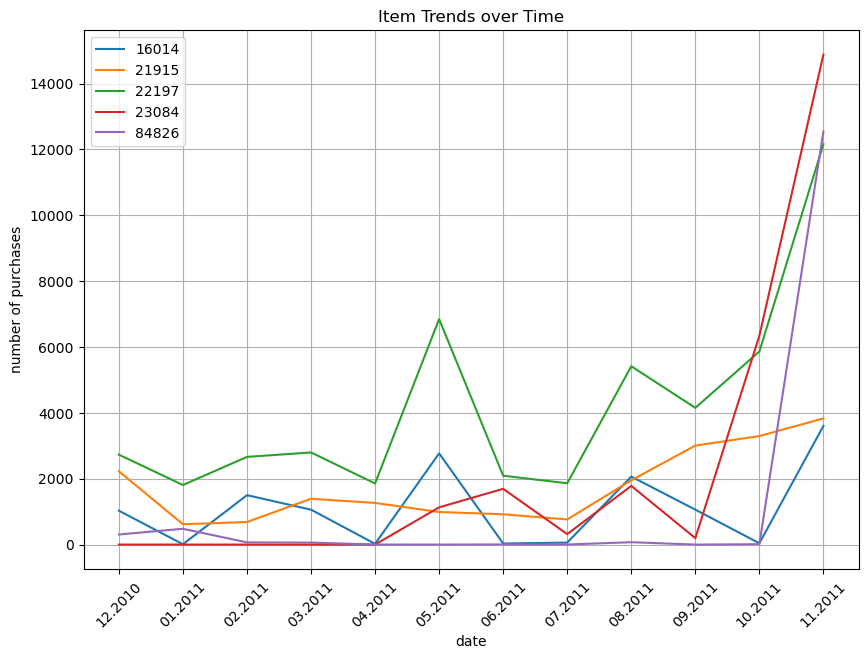

In [115]:
ax = pd.DataFrame(df_trending_itmes.values).plot(figsize=(10,7), grid=True)

ax.set_ylabel('number of purchases')
ax.set_xlabel('date')
ax.set_title('Item Trends over Time')

ax.legend(df_trending_itmes.columns, loc='upper left')

plt.xticks(
    range(len(df_trending_itmes.index)), 
    [x.strftime('%m.%Y') for x in df_trending_itmes.index], 
    rotation=45
)

plt.show()

It looks like the 5 identified top products from november 2011 are all christmas products, as they are not bought very much during the year, but only at the end of the year around christmas time.